## **I. Perkenalan**

Nama: Richie Devon Sumantri

_objective_ dari dokumen ini adalah membuat model _deep learning_ yang dapat melakukan kategorisasi jenis berita dari dokumen berita BBC dengan akurasi terbaik.

---

## **II. Import Libraries**

Tahap memuat modul yang akan digunakan.

In [54]:
# Library untuk data manipulasi 
import pandas as pd
import numpy as np
import copy
import json
import pickle

# Library Visualisasi
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Library Pengolahan Data
from tensorflow.keras.models import clone_model
from tensorflow.keras import Model
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download('punkt_tab')

# Library Tensorflow versi
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, LSTM, Bidirectional, GRU, Dropout, Reshape, Flatten, SimpleRNN, BatchNormalization
from tensorflow.keras.models import Sequential
import tensorflow as tf

# Library lainnya
from IPython.display import display, HTML

# Library personal fungsi
from function import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Max\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Max\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Max\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Max\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## **III. Data Loading**

Tahap memuat data dan pengecekan ukuran dari _dataset_.

_Dataset_ yang digunakan bernama BBC Full Text Document Classification yang berasal dari kaggle. Link terkait dengan dokumen ini adalah sebagai berikut: <a href='https://www.kaggle.com/datasets/alfathterry/bbc-full-text-document-classification'> Dataset </a>

In [3]:
# Penentuan nama dari file 
file_name = 'bbc_data.csv'

# Membuka data dari dokumen csv dan melakukan assign kepada dataframe
df = pd.read_csv(file_name)

# Pembuatan judul dari dataframe
display(HTML('<center><b><h3>BBC Full Text Dataset</h3></b></center>'))

# Menampilkan dataframe
display(df)

# Menampilkan informasi umum mengenai dataframe
df.info()

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment
...,...,...
2220,Warning over Windows Word files Writing a Mic...,tech
2221,Fast lifts rise into record books Two high-sp...,tech
2222,Nintendo adds media playing to DS Nintendo is...,tech
2223,Fast moving phone viruses appear Security fir...,tech


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    2225 non-null   object
 1   labels  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


**Insight**:

- Data terdiri dari 2225 Baris dan 2 Kolom
- Dari informasi umum fungsi `.info` tidak terlihat adanya _missing value_ pada ketiga kolom pada _dataframe_. 
- Kolom dataframe terdiri dari satu tipe yakni _object_.

**Penjelasan Kolom**:
1. **data**, merupakan data dokumen dari berita BBC. 
3. **labels**, merupakan informasi klasifikasi jenis berita dari BB. Jenis berita yang terdapat dalam data ini adalah sebagai berikut:
	- entertainment
	- sport
	- politics
	- tech
	- business 


## **IV. Exploratory Data Analysis (EDA)**

<div style='text-align: justify'>Tahap eksplorasi data menggunakan grouping, visualisasi sederhana dan lain-lain.
</div>

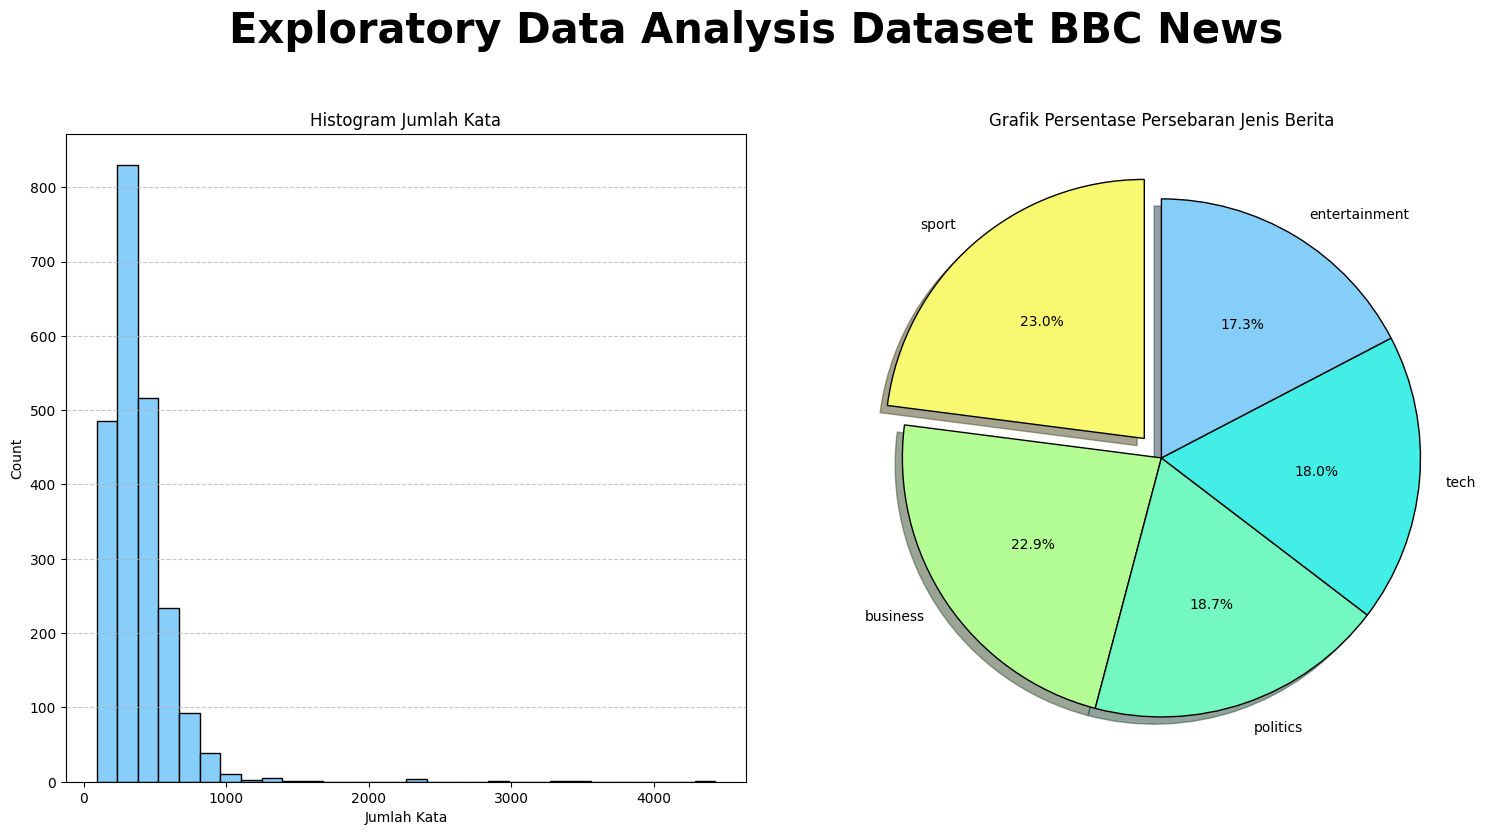

In [4]:
# Melakukan persalinan terhadap dataframe original
df_eda = df.copy()

# Pembuatan layout utama
fig = plt.figure(constrained_layout=True, figsize=(15, 14))

# Pembuatan gridspec yang terdiri dari 2 kolom dan 1 baris
gs = GridSpec(2, 2, figure=fig, hspace=0.1, wspace=0.1)

# Penentuan nama subplot dan koordinat subplot
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Pembuatan grafik pertama
df_eda['data_len'] = df_eda['data'].str.split().apply(len)
ax1.hist(df_eda['data_len'], bins=30, color='lightskyblue', edgecolor='black')
ax1.set_title('Histogram Jumlah Kata')
ax1.set_xlabel('Jumlah Kata')
ax1.set_ylabel('Count')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Pembuatan grafik kedua
ax2.pie(df_eda['labels'].value_counts().values, autopct='%1.1f%%', labels=list(df_eda['labels'].value_counts().index), colors=['#f9f871', '#b4fc94', '#72f8c0', '#43eee6', '#86cefa'],wedgeprops = {'edgecolor':'black'}, shadow=True, startangle=90, explode=(0.1, 0, 0, 0, 0))
ax2.set_title('Grafik Persentase Persebaran Jenis Berita')

plt.suptitle('Exploratory Data Analysis Dataset BBC News', fontsize=30,fontweight='bold', y=1.07)
plt.show()

**Insight**:

- Mayoritas berita dari BBC memiliki jumlah kata diantara 200 sampai 500 kata, namun masih terlihat beberapa berita yang memiliki isi yang cukup panjang yakni di atas 1000 kata. 
- Label dari berita terlihat tersebar cukup merata dan tidak ada berita yang mendapatkan porsi yang tidak seimbang. Jenis berita dengan jenis paling banyak adalah berita dengan jenis olahraga sementara berita paling sedikit adalah berita tentang _entertainment_.

## **V. Feature Engineering**

<div style='text-align: justify'>Tahap pengolahan data sebelum melakukan proses permodelan.
</div>

In [5]:
# Proses persalinan dataframe dari dataframe original
df_feat = df.copy()

### **1. Handling Data Duplikasi**

Pada tahap ini dilakukan pengecekan duplikasi data pada _dataframe_.

In [6]:
# Pengecekan data duplikasi
print(f'Jumlah data duplikat: {df_feat.duplicated().sum()}')

Jumlah data duplikat: 99


**Insight**:

- Berdasarkan pengecekan di atas terlihat bahwa dataset memiliki 99 data yang terduplikat. _Treatment_ yang akan dilakukan adalah melakukan penghapusan data duplikasi.

In [7]:
# Proses treatment penghapusan data duplikasi 
df_feat.drop_duplicates(inplace=True )

# Pengecekan data duplikasi
print(f'Jumlah data duplikat: {df_feat.duplicated().sum()}')

Jumlah data duplikat: 0


Terlihat bahwa data telah berhasil bersih dari duplikasi. 

### **2. Split Data**

Pada tahap ini dilakukan pemisahan data antara data _train_, _validation_ dan _test_.

In [8]:
# Pembuatan dataframe fitur
X = df_feat['data']

# Pembuatan dataframe target
y = df_feat['labels']

# Mapping pengubahan dataframe target menjadi bentuk numerik
mapping = {'business' : 0, 'entertainment' : 1,	'politics' : 2,	'sport' : 3, 'tech' : 4}

y = y.map(mapping)

**Penjelasan**:

- `X`: Merupakan variabel _dataframe_ yang menampung data _feature_ dalam permodelan.
- `y`: Merupakan variabel _dataframe_ yang menampung data target dalam permodelan.

In [9]:
# Pemisahan data test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Pemisahan data menjadi train dan validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

# Menampilkan Besar dari dataframe
print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (1535,)
Val Size   :  (272,)
Test Size  :  (319,)


**Penjelasan**:

Pemisahakan data dilakukan dengan mengambil _test_ sebesar 15% dari keseluruhan data dengan posisi keacakan dengan _state_ senilai 14.

### **3. Data Preprocessing**

Pada tahap ini dilakukan proses pengolahan data seperti penghapusan data, modifikasi data dan lain-lain.

In [10]:
# Penambahan stopword
with open('stop_words_english.txt', 'r', encoding="utf-8") as file:
	stop_words_list = file.read().splitlines()

# Inisialisasi pembuatan stopword bahasa inggris
stopword_eng = list(set(stopwords.words('english') + stop_words_list))

# Inisialisasi lematization
lemmatizer = WordNetLemmatizer()

# Proses preprocessing data
X_train = X_train.apply(text_preprocessing, stemmer=lemmatizer, stopword=stopword_eng)
X_val = X_val.apply(text_preprocessing, stemmer=lemmatizer, stopword=stopword_eng)
X_test = X_test.apply(text_preprocessing, stemmer=lemmatizer, stopword=stopword_eng)

# Menampilkan judul dari dataframe
display(HTML('<center><b><h3>Data X_train Setelah Preprocessing</h3></b></center>'))

# Menampilkan dataframe
X_train


82      child vote shrek film young uk film fan voted ...
1159    collins banned landmark case sprinter michelle...
293     tautou star da vinci film french actress audre...
1109    robinson dual code success england rugby union...
995     chelsea denied james heroic brave defensive di...
                              ...                        
1213    dawson set wasp contract european champion was...
1489    opposition grows house arrest conservative exp...
1298    man utd exeter test manchester united avoided ...
454     golden rule intact aide chancellor gordon brow...
1539    chancellor rally labour voter gordon brown iss...
Name: data, Length: 1535, dtype: object

**Penjelasan**:

- _Stopword_ yang digunakan dalam kasus ini adalah _stopword_ dengan bahasa inggris yang diisi ke dalam variabel `stopword_eng`. Guna dari proses ini adalah melakukan pemilihan terhadap kata-kata umum dalam bahasa inggris. 
- _lemmatizer_ yang digunakan adalah `WordNetLemmatizer`, dengan ini maka dapat dilakukan proses penyederhanaan dari masing-masing kata pada data.
- Proses selanjutnya adalah melakukan _preprocessing_ data dengan mengubah data menjadi huruf kecil, penghapusan simbol yang tidak dibutuhkan, _stopword_, _lemmatizer_ dan lain-lain. 


### **4. Target Conversion**

In [11]:
# Pengubahan data target menjadi label categorikal
y_train = to_categorical(y_train, num_classes=5)
y_val = to_categorical(y_val, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

Konversi _dicionary_ dari data target menjadi numerik adalah sebagai berikut.
- 0 : business
- 1 : entertainment
- 2 : politics
- 3 : sport
- 4 : tech

## **VI. ANN Training**

Tahap ini berisi pelatihan model Deep Learning menggunakan Sequential API

### **1. Model Definition**

Model yang digunakan dalam percobaan kali ini adalah SimpleRNN, model ini merupakan bagian dari _Neural Network_ yang dirancang untuk menangani data teks. Kelebihan dari model ini adalah fungsi aktivasi yang cenderung sederhana sehingga tidak membutuhkan _resource_ komputasi yang tinggi dan tidak memakan waktu yang cukup lama apabilai dibandingkan dengan model LSTM dan GRU. Namun kekurangan dari model ini adalah cenderung kurang akurat untuk data dengan _high dimensional_ karena bentuk data yang kompleks. 

Metrics yang dipilih dalam kasus ini adalah akurasi, pemilihan akurasi dikarenakan metrics ini lebih mudah diinterpretasikan, mencakup keseluruhan performa model dalam tingkat kategorisasi dari kelas maupun tingkat kebenaran dari prediksi. Dikarenakan data target tersebar tergolong cukup merata sehingga metrics ini dianggap tepat dalam permodelan kali ini.

### **2. Model Training**

Proses pelatihan model dimulai dengan penempatan beberapa layer dalam pembuatan Sequential API. Layer yang akan digunakan adalah sebagai berikut. 
- Input Layer, berupa proses pengubahan data numerikal menjadi vektor. 
- Hidden Layer pertama, berupa proses pengolahan data menggunakan model SimpleRNN dengan 128 Neuron
- Hidden Layer kedua, berupa proses pengolahan data menggunakan model SimpleRNN dengan 64 Neuron
- Ouput Layer, berupa penggabungan data menjadi 5 neuron serta menggunakan fungsi aktivasi `softmax`.

Proses pelatihan model akan menggunakan `callbacks` berupa _Early Stopping_ menggunakan tingkat toleransi perkembangan model senilai 5 epochs. Sementara pelatihan model ditargetkan berjalan sebanyak 30 epochs.

#### **Inisialisasi Vectorizer dan EarlyStop**

In [34]:
# Inisialisisi Vectorizer 
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_val_vec = Vectorize.transform(X_val)
X_test_vec = Vectorize.transform(X_test)
max_sen_len = max([len(i.split(" ")) for i in X_train])
total_vocab = len(Vectorize.vocabulary_.keys())

# Proses Vektorisasi
text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=(1,2),
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       encoding='utf-8',
                                       input_shape=(1,))  
text_vectorization.adapt(X_train)
X_train_vec = text_vectorization(X_train)
X_val_vec = text_vectorization(X_val)
X_test_vec = text_vectorization(X_test)

# Inisialisasi EarlyStop
EearlyStop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='auto',
    restore_best_weights=True,
)

c:\Users\Max\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\text_vectorization.py:340: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(name=name, **kwargs)


#### **Sequential Modelling SimpleRNN**

In [36]:
%%time

text_vectorizer = TextVectorization(max_tokens=total_vocab, output_mode='int')
text_vectorizer.adapt(X_train)  # Adapt the layer to the training data

# Pembuatan sesi dan seed
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Arsitektur Sequential modelling untuk Deep Learning
model = Sequential()

# Input Layer
model.add(Embedding(input_dim=total_vocab, output_dim=128))

# Hidden Layer
model.add(Bidirectional(SimpleRNN(128, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model.add(Bidirectional(SimpleRNN(64, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))

# Output Layer
model.add(Dense(5, activation="softmax"))

# Penentuan perhitungan loss, optimizer dan metrics
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Proses Training model
display(HTML('<center><b><h3>Proses Training Model SimpleRNN</h3></b></center>'))
history = model.fit(X_train_vec, y_train, epochs=30, validation_data=(X_val_vec, y_val), callbacks=[EearlyStop])

Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.2041 - loss: 1.6710 - val_accuracy: 0.2757 - val_loss: 1.5797
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.4650 - loss: 1.3026 - val_accuracy: 0.6103 - val_loss: 0.9861
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7471 - loss: 0.7063 - val_accuracy: 0.6985 - val_loss: 0.7258
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9191 - loss: 0.3378 - val_accuracy: 0.7390 - val_loss: 0.7103
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9851 - loss: 0.0980 - val_accuracy: 0.7537 - val_loss: 0.7011
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 1.0000 - loss: 0.0290 - val_accuracy: 0.7757 - val_loss: 0.6839
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 1.0000 - loss: 0.0165 - val_accuracy: 0.7684 - val_loss: 0.7380
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 1.0000 - loss: 0.0120 - val_accuracy: 0.7537 - val_loss:

### **3. Model Evaluation**

Model evaluasi dilakukan dengan menampilkan _classification report_ dan _confusion matrix_ sera melakukan analisis terhadap data yang mengalami misklasifikasi. 

#### **Visualisasi Performa Model**

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step

 ---------- Classification Report Model SimpleRNN ---------- 

              precision    recall  f1-score   support

           0       0.73      0.67      0.70        76
           1       0.53      0.59      0.56        54
           2       0.77      0.81      0.79        63
           3       0.90      0.93      0.91        69
           4       0.58      0.53      0.55        57

    accuracy                           0.71       319
   macro avg       0.70      0.71      0.70       319
weighted avg       0.71      0.71      0.71       319



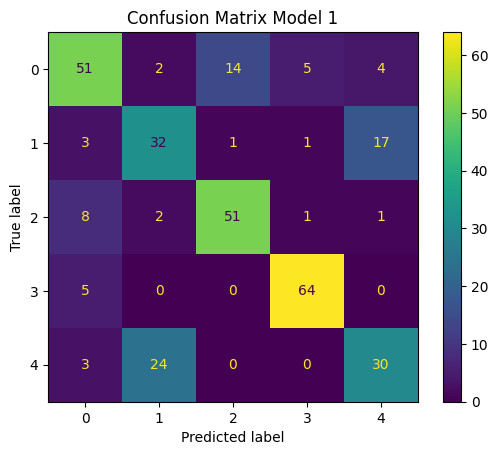

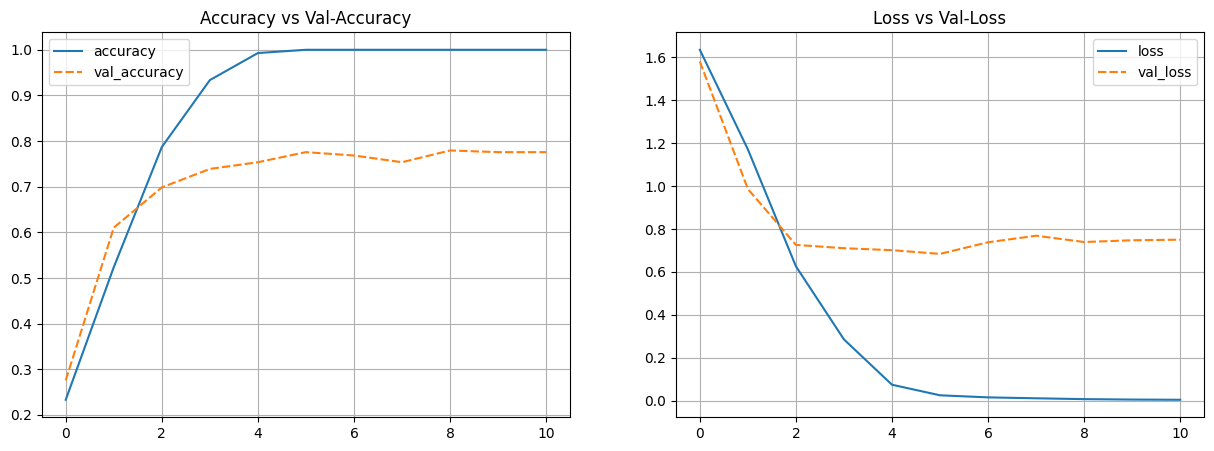

In [40]:
# Melakukan proses prediksi dari data test
y_pred = np.argmax(model.predict(X_test_vec), axis=1)

# Menampilkan Classification Report
print('\n', '-'*10, 'Classification Report Model SimpleRNN','-'*10, '\n')
print(classification_report(np.argmax(y_test, axis=1), y_pred))

# Pembuatan confusion matrix
confusion_matrix = metrics.confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Menampilkan confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.title('Confusion Matrix Model 1')
plt.show() 

# Pembuatan grafik performna
display(HTML('<center><b><h3>Grafik Tingkat Akurasi dan Loss</h3></b></center>'))
history_model_1 = pd.DataFrame(history.history)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_model_1[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.subplot(1, 2, 2)
sns.lineplot(data=history_model_1[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

**Insight**:

- Terlihat bahwa model setelah melakukan proses _train_ mendapatkan nilai akurasi pada data validasi dengan besar kurang lebih 70% sampai 80%. Sementara model setelah melakukan beberapa iterasi di awal cukup mudah untuk mencapai akurasi 100%. terlihat setelah melakukan pembelajaran bahwa setelah 5 epochs terakhir bahwa tidak ada perkembangan val_loss sehingga model memutuskan untuk memberhentikan proses _train_ dan mengambil history model dengan nilai val_loss paling kecil yakni pada epochs ke-6. 
- Akurasi pada data validasi tergolong sedang, sekitar 70% dari data validasi dapat diprediksi dengan benar sementara sisanya mengalami misklasifikasi. Model _deep learning_ ini cenderung _overfitting_ ketika dibandingkan dengan nilai akurasi pada data _train_ sebesar 100%.
- Pengetesan model pada data _test_ menghasilkan akurasi yang relatif kecil yakni di 71%.
- Prose _train_ model cenderung singkat yakni selama 11 menit dan 19 detik. 
- Model ini dapat memberikan prediksi yang cukup akurat namun tidak maksimal dikarenakan model SimpleRNN memiliki fungsi aktivasi yang sederhana sehingga ketika berhadapan dengan data dimensi tinggi akan mengalami kesusahan dalam meninjau data baru. 

#### **Menampilkan Data Test Misklasifikasi**

Data misklasifikasi akan ditampilkan untuk melakukan analisis terkait kemampuan model dalam melakukan kategorisasi pada target. 

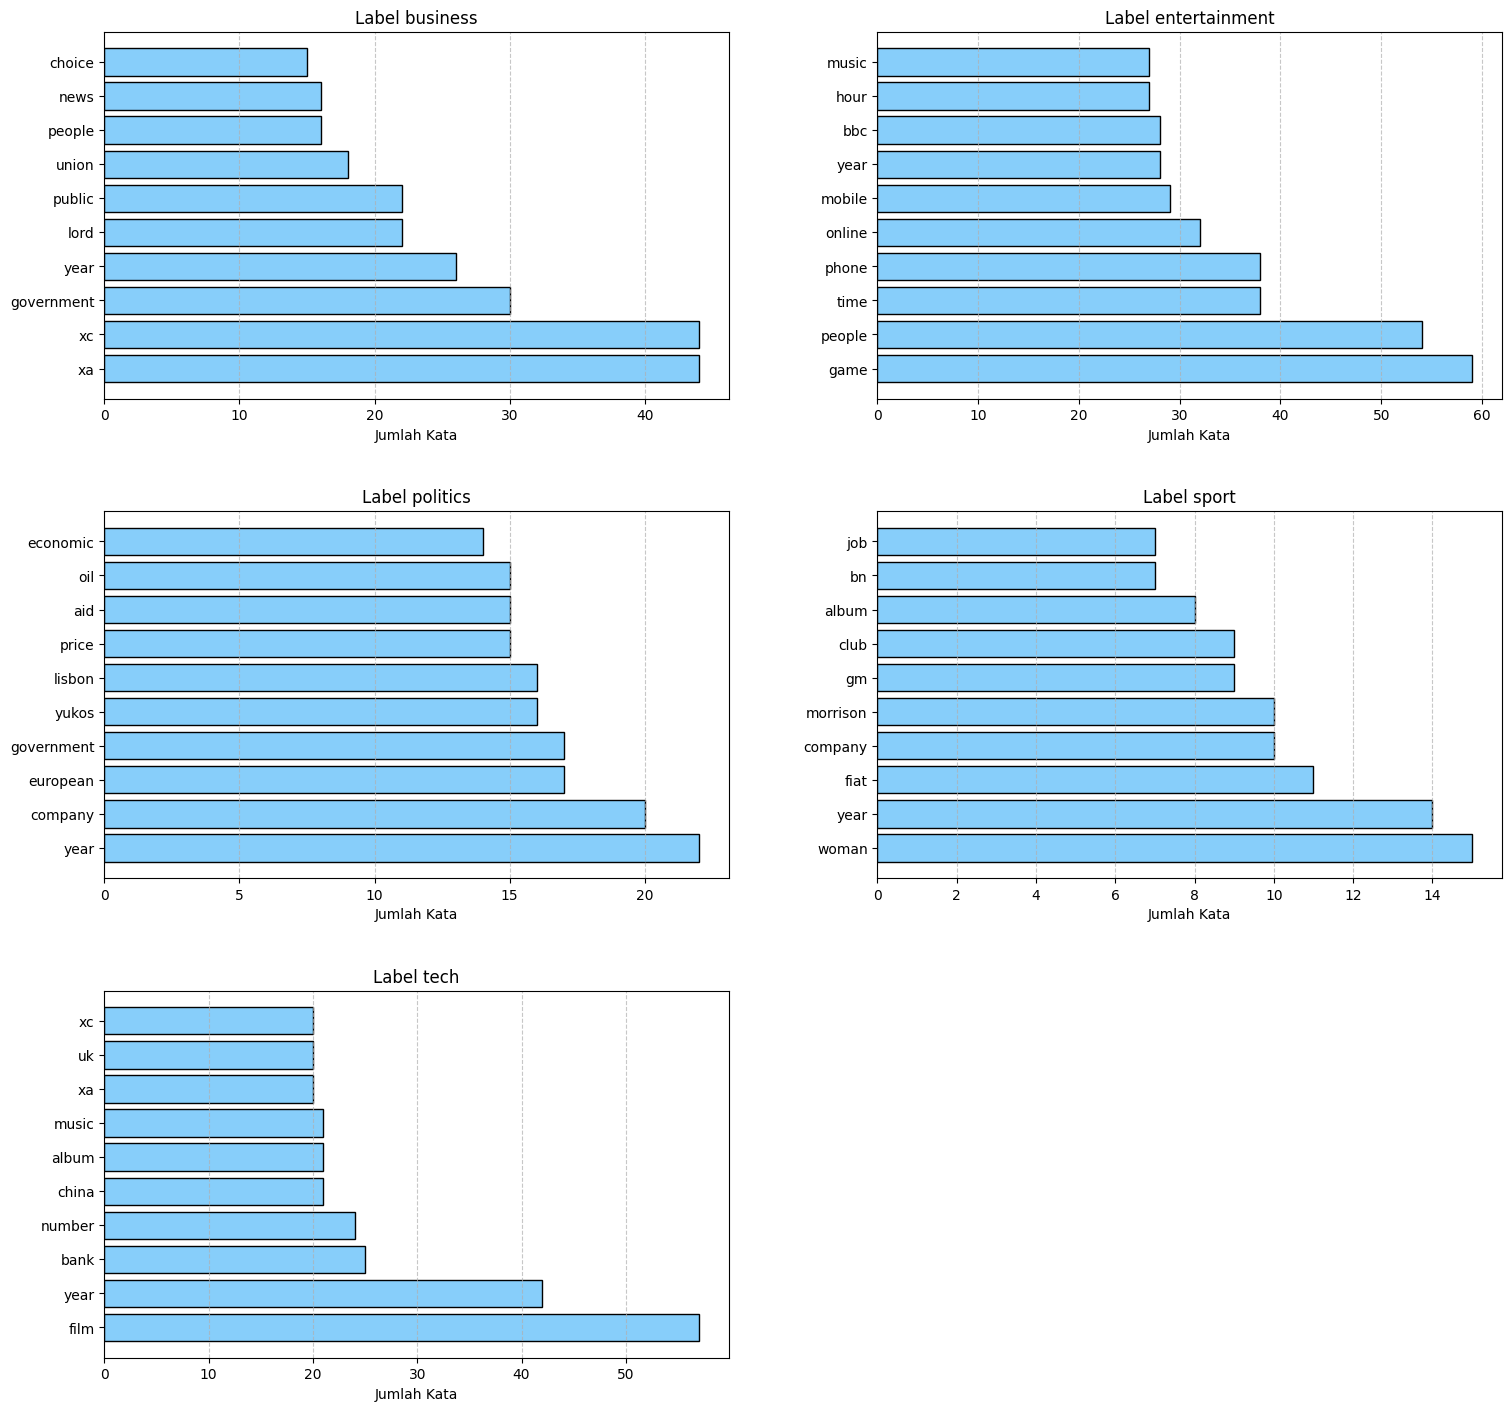

In [41]:
# Pembuatan layout utama
fig = plt.figure(constrained_layout=True, figsize=(15, 14))

# Pembuatan gridspec yang terdiri dari 2 kolom dan 1 baris
gs = GridSpec(3, 2, figure=fig, hspace=0.1, wspace=0.1)

# Penentuan nama subplot dan koordinat subplot
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])

# Pengubahan data menjadi series
y_pred_series = pd.Series(y_pred, name='pred') 
y_test_series = pd.Series(np.argmax(y_test, axis=1), name='label')

# Penggabungan data kembali menjadi satu dataframe
display(HTML('<center><b><h3>Kata Yang Paling Sering Muncul Pada Misklasifikasi</h3></b></center>'))
misclasification_data = pd.concat([X_test.reset_index(), y_test_series, y_pred_series], axis=1, ignore_index=True).rename(columns={0 : 'Index', 1: 'data', 2: 'label', 3:'pred'})
misclasification_data = misclasification_data[misclasification_data['label'] != misclasification_data['pred']]

# Pembuatan grafik
for index, ax in enumerate([[ax1, 'business'], [ax2, 'entertainment'], [ax3, 'politics'], [ax4, 'sport'], [ax5, 'tech']]):
	pred_list = list(misclasification_data[misclasification_data['pred'] == index]['data'])
	words = [word for text in pred_list for word in text.split()]

	dictionary = {}
	for word in set(words):
		count = words.count(word)
		dictionary[word] = count

	df_bar = pd.DataFrame(dictionary, index=(range(len(dictionary)))).transpose().iloc[:,1].sort_values(ascending=False).nlargest(10)
	ax[0].barh(y=df_bar.index, width=df_bar.values, color='lightskyblue', edgecolor='black')
	ax[0].set_title(f'Label {ax[1]}')
	ax[0].set_xlabel('Jumlah Kata')
	ax[0].grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

**Insight**:
- Terlihat bahwa pada setiap label bahwa banyak memiliki kata 'year' & 'people' pada data klasifikasi, hal ini dapat dikarenakan oleh kata ini termasuk dalam kategori yang umum sehingga dapat masuk ke dalam beberapa label berita. Hal ini juga sama dengan kata-kata lain seperti 'game', 'time' dan lain-lain

## **VII. ANN Improvement**

Tahap ini berisi perkembangan model Deep Learning menggunakan Sequential API

### **1. Model Definition**

Model yang digunakan adalah Long Short-Term Memory (LSTM), model ini merupakan bagian dari _Neural Network_ yang dirancang untuk menangani data teks sehingga cocok untuk kasus kali ini. Model lain untuk penanganan kasus _Natural Language Processing_ adalah GRU dan SimpleRNN, pemilihan LSTM sebagai model dikarenakan merupakan model yang paling kompleks secara perhitungan aktivasi fungsi sehingga diharapkan menghasilkan model yang paling optimal dan akurat. Namun kekurangan dari model ini adalah menggunakan komputasi yang tinggi sehingga memerlukan waktu yang lebih lama dalam proses _train_ model. 

Metrics yang dipilih dalam kasus ini adalah akurasi, pemilihan akurasi dikarenakan metrics ini lebih mudah diinterpretasikan, mencakup keseluruhan performa model dalam tingkat kategorisasi dari kelas maupun tingkat kebenaran dari prediksi. Dikarenakan data target tersebar tergolong cukup merata sehingga metrics ini dianggap tepat dalam permodelan kali ini.

Diharapkan dengan pemilihan model yang lebih kompleks dalam fungsi aktivasi maka dapat menghasilkan data yang lebih akurat dari pada model sebelumnya. 

### **2. Model Training**

Proses pelatihan model dimulai dengan penempatan beberapa layer dalam pembuatan Sequential API. Layer yang akan digunakan adalah sebagai berikut. 
- Input Layer, berupa proses pengubahan data numerikal menjadi vektor. 
- Hidden Layer pertama, berupa proses pengolahan data menggunakan model LSTM dengan 64 Neuron
- Hidden Layer kedua, berupa proses pengolahan data menggunakan model LSTM dengan 128 Neuron
- Hidden Layer ketiga, berupa proses pengolahan data menggunakan model LSTM dengan 128 Neuron
- Hidden Layer keempat, berupa proses pengolahan data menggunakan model LSTM dengan 64 Neuron
- Ouput Layer, berupa penggabungan data menjadi 5 neuron serta menggunakan fungsi aktivasi `softmax`.

Proses pelatihan model akan menggunakan `callbacks` berupa _Early Stopping_ menggunakan tingkat toleransi perkembangan model senilai 5 epochs. Sementara pelatihan model ditargetkan berjalan sebanyak 30 epochs.

Penambahan Hidden layer digunakan agar model _deep learning_ dapat melihat banyak konteks dengan meningkatkan jumlah layer serta neuron, maka diharapkan dengan banyaknya variasi _network_ yang terbangun dapat memberikan hasil yang lebih optimal. 

#### **Sequential Modelling LSTM**

In [43]:
%%time

# Pembuatan sesi dan seed
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Arsitektur Sequential modelling untuk Deep Learning
model_2 = Sequential()

# Input Layer
model_2.add(Embedding(input_dim=total_vocab, output_dim=256))

# Hidden Layer
model_2.add(Bidirectional(LSTM(64, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_2.add(Dropout(0.1))
model_2.add(Bidirectional(LSTM(128, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_2.add(Dropout(0.1))
model_2.add(Bidirectional(LSTM(128, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_2.add(Dropout(0.1))
model_2.add(Bidirectional(LSTM(64, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_2.add(Dropout(0.1))

# Output Layer
model_2.add(Dense(5, activation="softmax"))

# Penentuan perhitungan loss, optimizer dan metrics
model_2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Proses Training model_2
display(HTML('<center><b><h3>Proses Training model_2 LSTM</h3></b></center>'))
history_2 = model_2.fit(X_train_vec, y_train, epochs=30, validation_data=(X_val_vec, y_val), callbacks=[EearlyStop])

Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 283s 6s/step - accuracy: 0.4513 - loss: 1.2624 - val_accuracy: 0.9118 - val_loss: 0.3430
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 283s 6s/step - accuracy: 0.9547 - loss: 0.1769 - val_accuracy: 0.9154 - val_loss: 0.2608
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 288s 6s/step - accuracy: 0.9746 - loss: 0.1078 - val_accuracy: 0.9301 - val_loss: 0.2742
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 290s 6s/step - accuracy: 0.9947 - loss: 0.0354 - val_accuracy: 0.9522 - val_loss: 0.2068
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 304s 6s/step - accuracy: 0.9988 - loss: 0.0148 - val_accuracy: 0.9632 - val_loss: 0.1670
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 299s 6s/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.9632 - val_loss: 0.1671
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 298s 6s/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 0.9706 - val_loss: 0.1675
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 292s 6s/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9706 - v

### **3. Model Evaluation**

Model evaluasi dilakukan dengan menampilkan _classification report_ dan _confusion matrix_ sera melakukan analisis terhadap data yang mengalami misklasifikasi. 

#### **Visualisasi Performa Model**

10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step

 ---------- Classification Report Model LSTM ---------- 

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        76
           1       0.91      0.94      0.93        54
           2       0.97      0.95      0.96        63
           3       1.00      0.99      0.99        69
           4       0.90      0.95      0.92        57

    accuracy                           0.95       319
   macro avg       0.95      0.95      0.95       319
weighted avg       0.95      0.95      0.95       319



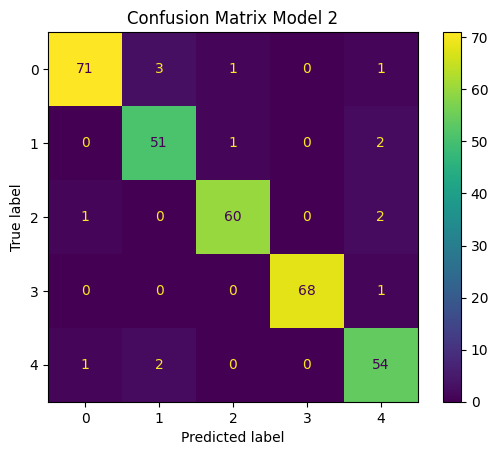

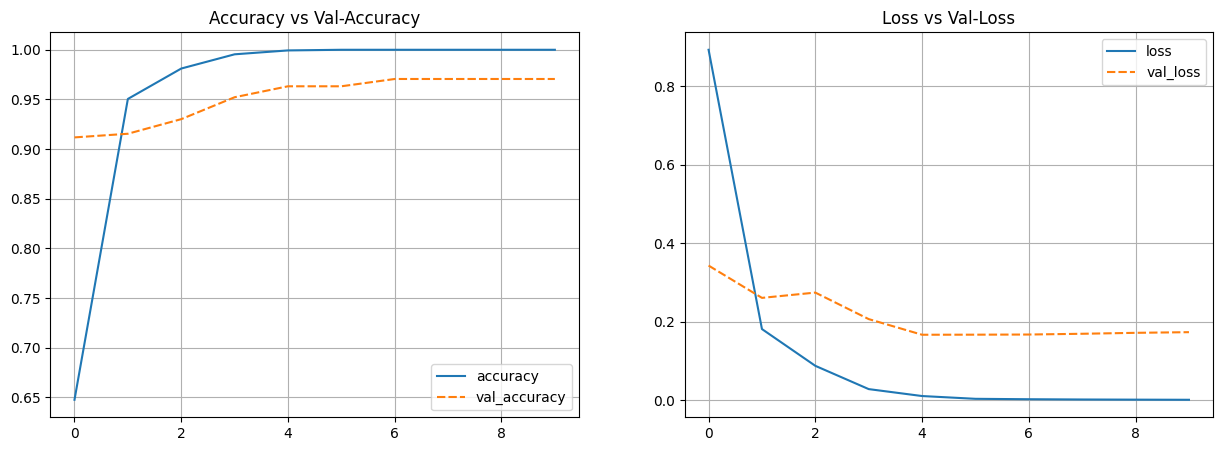

In [46]:
# Melakukan proses prediksi dari data test
y_pred = np.argmax(model_2.predict(X_test_vec), axis=1)

# Menampilkan Classification Report
print('\n', '-'*10, 'Classification Report Model LSTM','-'*10, '\n')
print(classification_report(np.argmax(y_test, axis=1), y_pred))

# Pembuatan confusion matrix
confusion_matrix = metrics.confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Menampilkan confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.title('Confusion Matrix Model 2')
plt.show() 

# Pembuatan grafik performna
display(HTML('<center><b><h3>Grafik Tingkat Akurasi dan Loss</h3></b></center>'))
history_model_2 = pd.DataFrame(history_2.history)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_model_2[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.subplot(1, 2, 2)
sns.lineplot(data=history_model_2[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

**Insight**:

- Terlihat bahwa model setelah melakukan proses _train_ mendapatkan nilai akurasi pada data validasi dengan besar kurang lebih 90% sampai 976%. Sementara model setelah melakukan beberapa iterasi untuk mencapai akurasi 100% yakni 5 epochs. terlihat setelah melakukan pembelajaran bahwa setelah 5 epochs terakhir bahwa tidak ada perkembangan val_loss sehingga model memutuskan untuk memberhentikan proses _train_ dan mengambil history model dengan nilai val_loss paling kecil yakni pada epochs ke-5. 
- Akurasi pada data validasi tergolong sangat akurat, sekitar 97% dari data validasi dapat diprediksi dengan benar sementara sisanya mengalami misklasifikasi. Model _deep learning_ ini _overfitting_ dalam skala yang cenderung kecil yakni dengan selisih kurang lebih 3% sampai 4%
- Pengetesan model pada data _test_ menghasilkan akurasi 95%.
- Prose _train_ model memerlukan waktu selama 48 menit dan 54 detik. 
- Model LSTM dapat memberikan prediksi yang akurat dikarenakan memiliki fungsi aktivasi yang kompleks sehingga berhadapan dengan data berdimensi tinggi dapat melihat konteks tertentu ketika dibandingkan dengan model yang lebih sederhana. 

#### **Menampilkan Data Test Misklasifikasi**

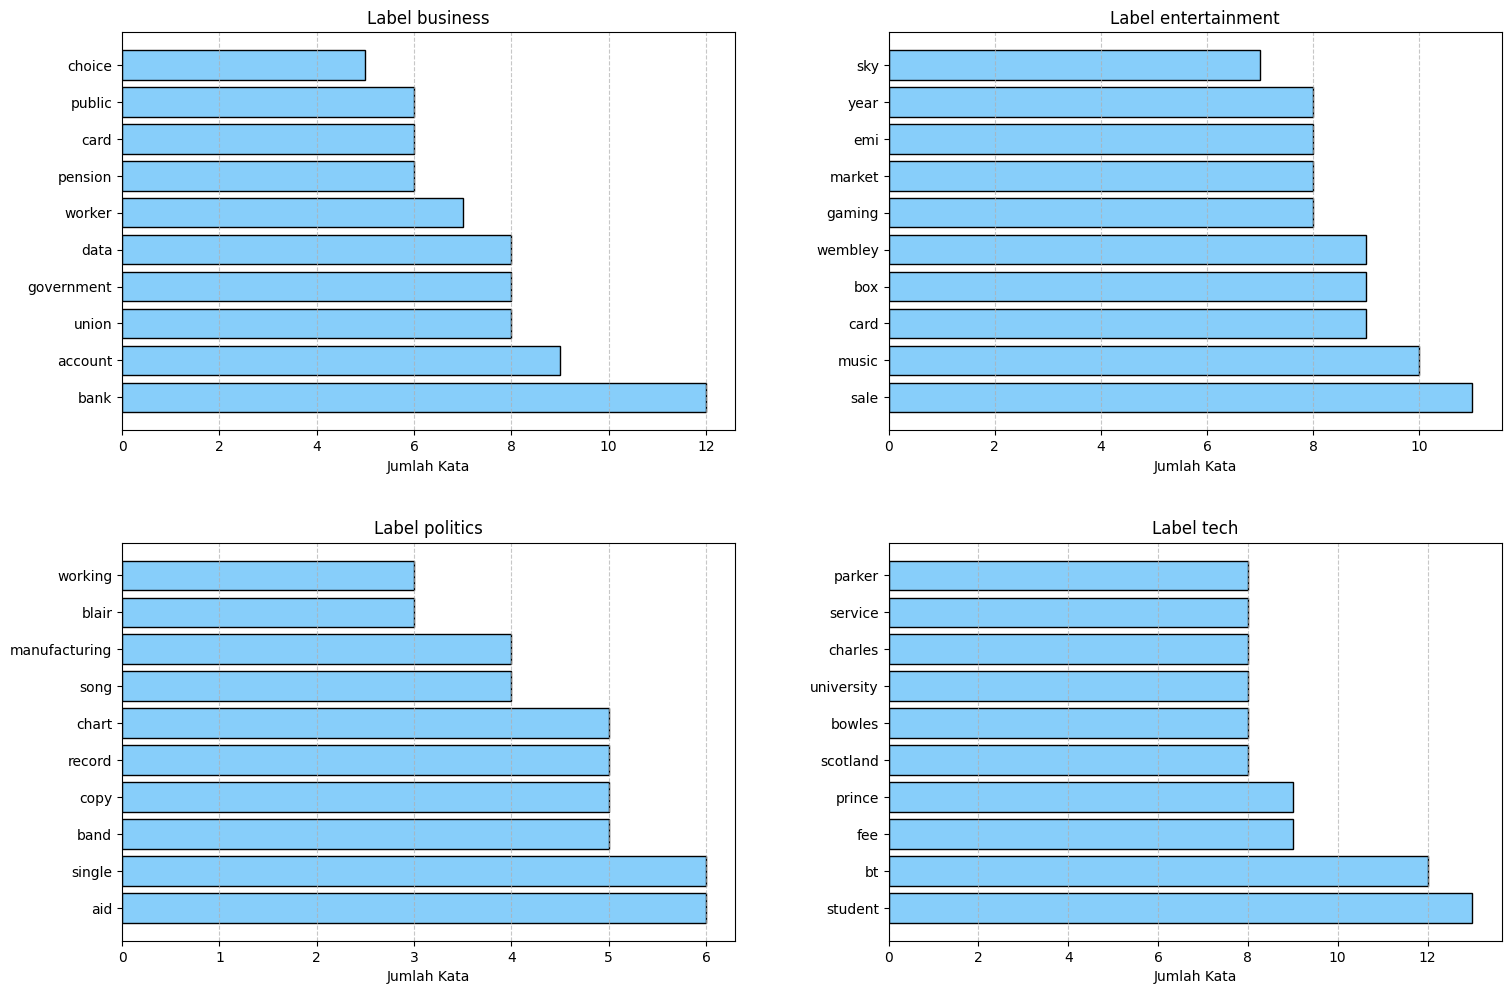

In [48]:
# Pembuatan layout utama
fig = plt.figure(constrained_layout=True, figsize=(15, 14))

# Pembuatan gridspec yang terdiri dari 2 kolom dan 1 baris
gs = GridSpec(3, 2, figure=fig, hspace=0.1, wspace=0.1)

# Penentuan nama subplot dan koordinat subplot
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])

# Pengubahan data menjadi series
y_pred_series = pd.Series(y_pred, name='pred') 
y_test_series = pd.Series(np.argmax(y_test, axis=1), name='label')

# Penggabungan data kembali menjadi satu dataframe
display(HTML('<center><b><h3>Kata Yang Paling Sering Muncul Pada Misklasifikasi</h3></b></center>'))
misclasification_data = pd.concat([X_test.reset_index(), y_test_series, y_pred_series], axis=1, ignore_index=True).rename(columns={0 : 'Index', 1: 'data', 2: 'label', 3:'pred'})
misclasification_data = misclasification_data[misclasification_data['label'] != misclasification_data['pred']]

# Pembuatan grafik
for index, ax in enumerate([[ax1, 'business'], [ax2, 'entertainment'], [ax3, 'politics'], [ax4, 'sport'], [ax5, 'tech']]):
	pred_list = list(misclasification_data[misclasification_data['pred'] == index]['data'])
	words = [word for text in pred_list for word in text.split()]

	dictionary = {}
	for word in set(words):
		count = words.count(word)
		dictionary[word] = count

	if len(dictionary) > 0 :
		index_list = [f"Item {i}" for i in range(len(dictionary))]
		df_bar = pd.DataFrame(dictionary, index=index_list).transpose().iloc[:,1].sort_values(ascending=False).nlargest(10)
		ax[0].barh(y=df_bar.index, width=df_bar.values, color='lightskyblue', edgecolor='black')
		ax[0].set_title(f'Label {ax[1]}')
		ax[0].set_xlabel('Jumlah Kata')
		ax[0].grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

## **VIII. Model Saving**

Tahap ini berisi proses penyimpanan model menjadi _file external_. 

In [61]:
# Penyimpanan Model 
model_2.save('model.h5')

# Penyimpanan teks vectorizer
config = text_vectorizer.get_config()
vocab = text_vectorizer.get_vocabulary()

with open('text_vectorizer_config.json', 'w') as f:
    json.dump(config, f)
    
with open('text_vectorizer_vocab.txt', 'w') as f:
    f.write('\n'.join(vocab))

with open('max_sen_len.txt', 'w') as f:
    f.write(str(max_sen_len))

with open('total_vocab.txt', 'w') as f:
    f.write(str(total_vocab))
    
with open('train.pickle', 'wb') as f:
    pickle.dump(X_train, f)

## **IX. Kesimpulan**

**Insight**:

- Mayoritas berita dari BBC memiliki jumlah kata diantara 200 sampai 500 kata, namun masih terlihat beberapa berita yang memiliki isi yang cukup panjang yakni di atas 1000 kata. 
- Jenis berita dari keseluruhan isi dokumen BBC adalah berita olahraga, hiburan, teknologi, bisnis dan politik. 
- Label dari berita terlihat tersebar cukup merata dan tidak ada berita yang mendapatkan porsi yang tidak seimbang. Jenis berita dengan jenis paling banyak adalah berita dengan jenis olahraga sementara berita paling sedikit adalah berita tentang _entertainment_.
- Model _deep learning_ yang dipilih adalah dengan menggunakan jaringan berupa LSTM yang memiliki tinggi akurasi sebesar 95%. Maka dari itu 95% dari pengelompokkan berita berdasarkan isi dari berita tersebut benar sebesar 95%. 
- Model ini memiliki jangka waktu pembelajaran yang cukup lama ketika dibandingkan dengan menggunakan jaringan lain seperti SimpleRNN
- Model ini menggunakan empat hidden layer LSTM dengan jumlah neuron sebagai berikut 64, 128, 128 dan 64. 
